<a href="https://colab.research.google.com/github/anupj/Vision-Transformer-Implementation-in-PyTorch/blob/main/PyTorch_Vision_Transformer_Paper_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Vision Transformer Paper Implementation in PyTorch

The goal of this project is to turn a ML research paper into code.

In this notebook, we'll replicate the Vision Transformer (ViT) architecture [paper](https://arxiv.org/abs/2010.11929).
[link text](https://)

## 0. Getting Setup

Let's import code we've previously written + required libraries like `torchinfo`.

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Since we're continuing on with FoodVision Mini, let's download the pizza, steak and sushi image dataset we've been using.

To do so we can use the `download_data()` function from `helper_functions.py` that we created before.

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Let's start by creating `DataLoaders` using `create_dataloaders()` function we've written before and imported in our `going_modular` folder.

First we'll create a *transform* to *prepare* our images. How will we determine the image size?

This is where we can refer to the ViT paper to see if they've provided this information. And indeed in **Table 3** - `Hyperparameters for Training` we can see that the training resolution is **224**, and the batch size is **4096**.

Given our limited Google Colab resources, we won't be using that big of a batch size, instead we'll stick with batch size of 32. Onwards.

### 2.1 Prepare transforms for images

In [7]:
# Set image size hyperparameter
IMG_SIZE = 224 # as mentioned in the ViT paper

from torchvision import transforms
from going_modular.going_modular import data_setup

# Since we are not using transfer learning to begin with, we'll create our transform manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader's`

As mentioned above, we'll keep our batch size as 32, and we'll set `pin_memory=True`.

> **Note**: We're using the pin_memory=True parameter in the `create_dataloaders()` function to speed up computation. `pin_memory=True` avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small). However, setting `pin_memory=True` doesn't always improve performance (this is another one of those we're scenarios in machine learning where some things work sometimes and don't other times), so best to *experiment, experiment, experiment*.

In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image



image.shape: torch.Size([3, 224, 224]), label: 2


(-0.5, 223.5, 223.5, -0.5)

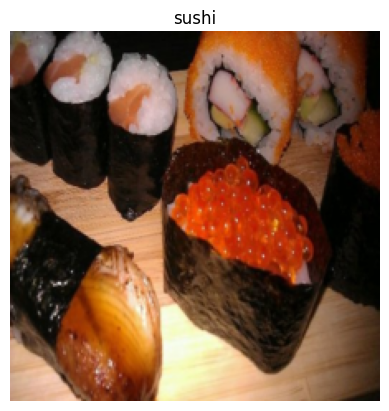

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shape
print(f"image.shape: {image.shape}, label: {label}") # label is a scalar

# Plot the image with mathplotlib
import matplotlib.pyplot as plt

# permute the image because matplot lib prefers (height, width, color_channels) whereas pytorch prefers (color_channels, height, width)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?




### 3.1. Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the *whole architecture*.

A *layer* takes an **input** (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an **output**.

So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

However, the main three resources we'll be looking at for the architecture design are:

* **Figure 1** - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)
* **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png)
* **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-table-1.png)


#### 3.2.1. Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:

1. **Layers** - takes an input, performs an operation or function on the input, produces an output.
2. **Blocks** - a collection of layers, which in turn also takes an input and produces an output.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)
*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.

* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable representation (typically in the form of a vector)* of the image that can improve with training.

* **Norm** - This is short for **Layer Normalization** or **LayerNorm**, a technique for *regularizing* (reducing overfitting) a neural network, you can use **LayerNorm** via the PyTorch layer `torch.nn.LayerNorm()`.

* **Multi-Head Attention** - This is a **Multi-Headed Self-Attention layer** or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.

* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them (section 3.1) and a `torch.nn.Dropout()` layer after each (Appendix B.1).

* **Transformer Encoder** - The **Transformer Encoder**, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the `+` symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.

* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png)
*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*


#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

**These four equations represent the math behind the four major parts of the ViT architecture.**


Let's map these descriptions to the ViT architecture in Figure 1.
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer prime" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```
Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview
$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).


#### 3.2.5 Equation 3 overview
$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model      | Layers | Hidden size $D$ | MLP size | Heads | Params |
|-----------|--------|-----------------|----------|-------|--------|
| ViT-Base	| 12	   |768	             |3072      |	12	  | $86M$  |
| ViT-Large	| 24	   | 1024	           | 4096	    | 16    | $307M$ |
| ViT-Huge	| 32	   | 1280	           | 5120	    | 16    |$632M$  |
*Table 1: Details of Vision Transformer model variants. Source: ViT paper.*

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:

* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more computation.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more computation. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split image input into patches and creating the class, position, and patch embedding

We'll start with the **patch embedding**.

This means we'll be turning our input images in *a sequence of patches and then embedding those patches*.

Recall that an embedding is a **learnable representation** of some form and is often a vector.

The term *learnable* is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper
>The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is 224.

Let's break down the text above.

- $D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.
- The image starts as 2D with size ${H \times W \times C}$.
  - $(H, W)$ is the resolution of the original image (height, width).
  - $C$ is the number of channels.
- The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
  - $(P, P)$ is the resolution of each image patch (patch size).
  - $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png)


### 4.1 4.1 Calculating patch embedding input and output shapes by hand

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).



In [10]:
# Create example values
height = 224 # H ("The training resolution is 224")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196



We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

* **Input**: The image starts as 2D with size ${H \times W \times C}$.
* **Output**: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [11]:
# Embedding layer Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Embedding layer Output shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2 * color_channels))

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape} -> ()")


Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768) -> ()


### 4.2 Turning a single image into patches

Let's start simple with our single image

(-0.5, 223.5, 223.5, -0.5)

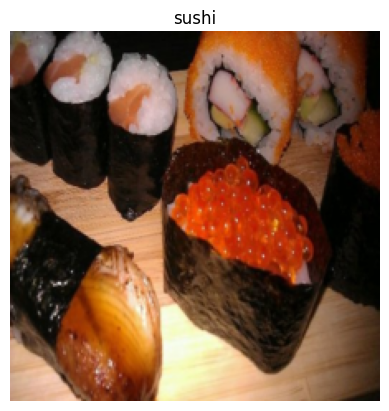

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # [c, h, w] -> [h, w, c] for matplotlib
plt.title(class_names[label])
plt.axis(False)

Let's start by visualising just the top row of patched pixels.

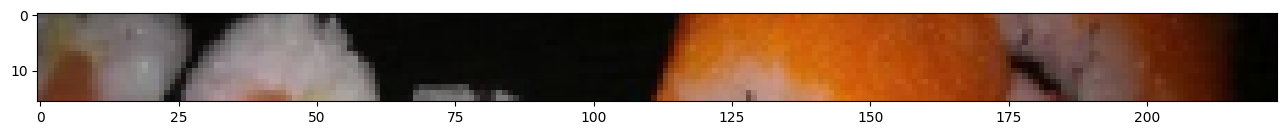

In [13]:
# assign the matplot compatible permuted image to its own variable
image_permuted = image.permute(1, 2, 0)

# Plot the top row of patched pixel
patch_size = 16
plt.figure(figsize=(patch_size, patch_size)) # set the size of figure canvas display
plt.imshow(image_permuted[:patch_size, :, :]) # only show 16 pixels row, and all columns, and all color_channels of the image

Ok, now let's turn it into patches

num_of_patches per row 14.0
Patch size: 16 pixels x 16 pixels


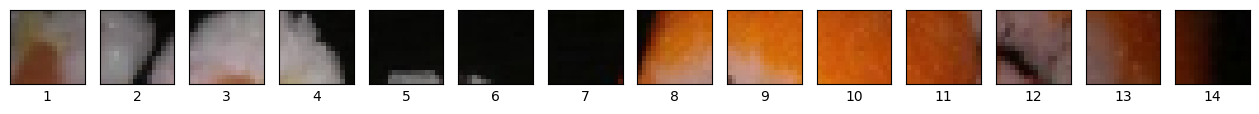

In [14]:
# First let's calculate the number of patches
image_size = 224
# Number of patches will be image_size divided by a single patch_size
# Also throw an error if image size is not exactly divisible by patch size
if image_size % patch_size != 0:
  raise ValueError(f"Image size {image_size} must be divisible by patch_size {patch_size}")

num_of_patches = image_size / patch_size # 224 / 16 = 14

print(f"num_of_patches per row {num_of_patches}")
print(f"Patch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                         ncols=image_size // patch_size, # floor division 224 // 16 = 14 cols
                         figsize=(patch_size, patch_size),
                         sharex=True,
                         sharey=True)


# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)): # range(0, 224, 16) -> jumps of 16 between 0 and 224
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])


In [19]:
class_names[label]

'sushi'

Let's update the code above to get the whole image.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


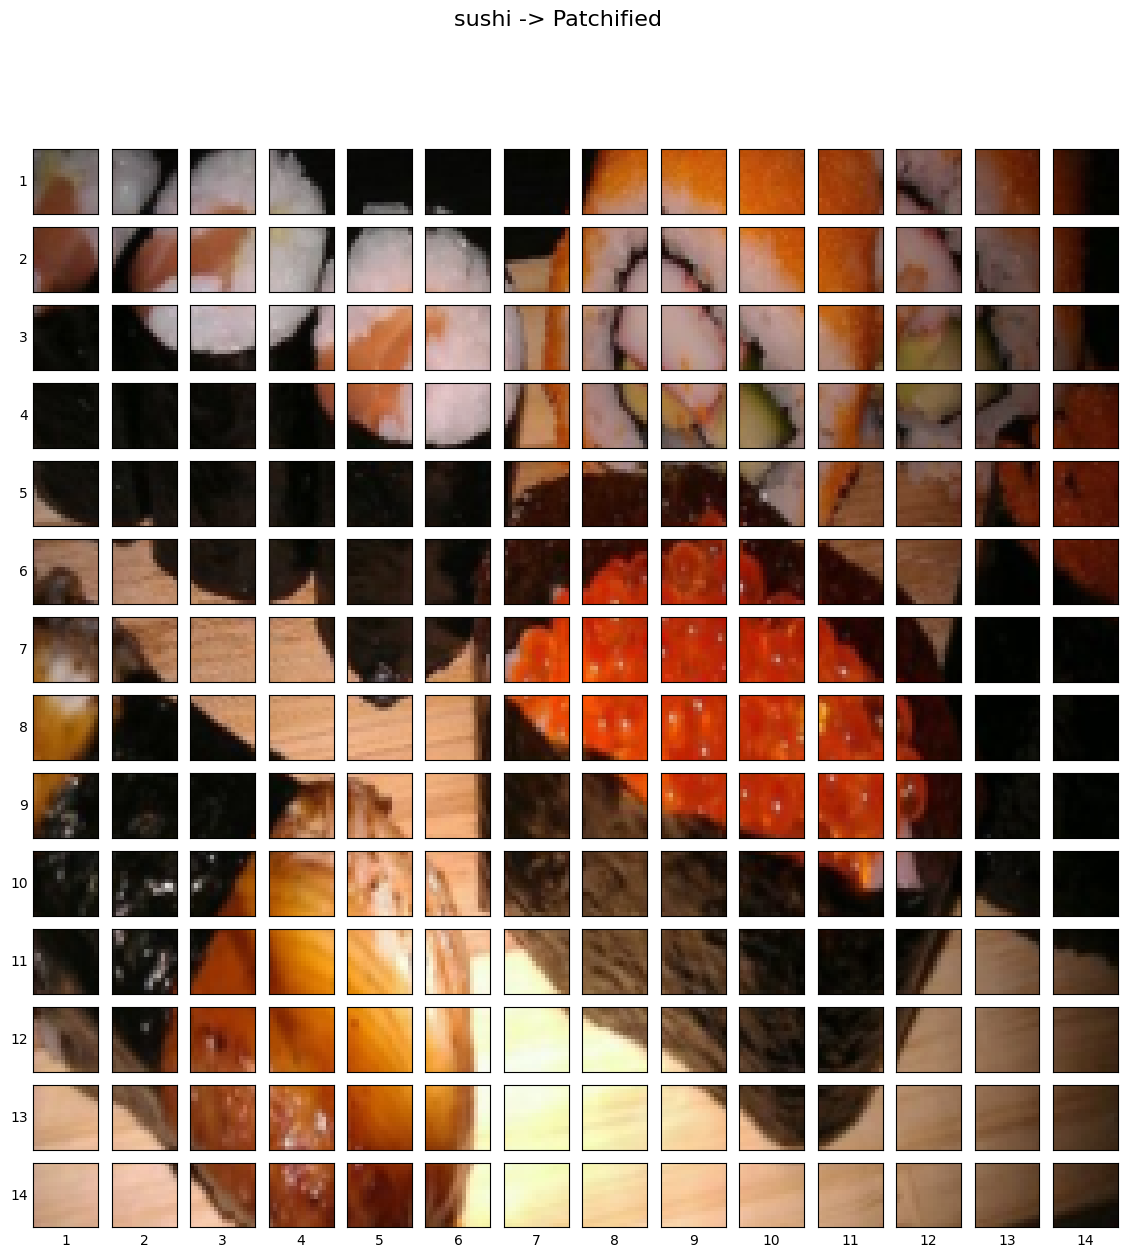

In [22]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches with `torch.nn.Conv2d()`

We could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the `kernel_size` and `stride` parameters to `patch_size`.

We get this idea from section 3.1 of the ViT paper:
> **Hybrid Architecture** - As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

Our ideal input and output shapes for the patch embedding layer?

* **Input**: The image starts as 2D with size ${H \times W \times C}$.
* **Output**: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image)**: (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches)**: (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

In [24]:
from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels = 3, # number of color channels
    out_channels = 768, # from Table 1: Hidden size D
    kernel_size=patch_size, # could also use (patch_size, patch_size)
    stride = patch_size,
    padding = 0,
)

Ok, let's pass a single image through it

(-0.5, 223.5, 223.5, -0.5)

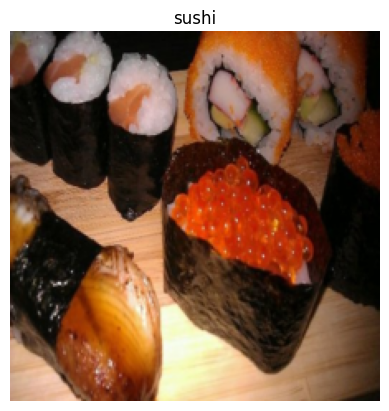

In [25]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [26]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])
